# Imports
Import all the necessary libraries required for the project.

In [27]:
# **Imports**:
%pip install numpy pandas matplotlib seaborn scikit-learn
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Load Dataset
Load the dataset that will be used for training and testing the model.

In [28]:
# **Load Dataset**
# Load the dataset into a pandas DataFrame
dataset_path = '../sample_data/CEAS_08.csv'
df = pd.read_csv(dataset_path)

# Data Preprocessing
Perform data cleaning and preprocessing steps to prepare the data for modeling.

In [29]:
# **Data Preprocessing**
# Check for missing values
missing_values = df.isnull().sum()
df = df.dropna()
missing_values = df.isnull().sum()# Print
print(missing_values)
df.shape

sender      0
receiver    0
date        0
subject     0
body        0
label       0
urls        0
dtype: int64


(38669, 7)

# Train Model

Accuracy: 0.9896560641324024
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6782
           1       0.99      0.99      0.99      8686

    accuracy                           0.99     15468
   macro avg       0.99      0.99      0.99     15468
weighted avg       0.99      0.99      0.99     15468



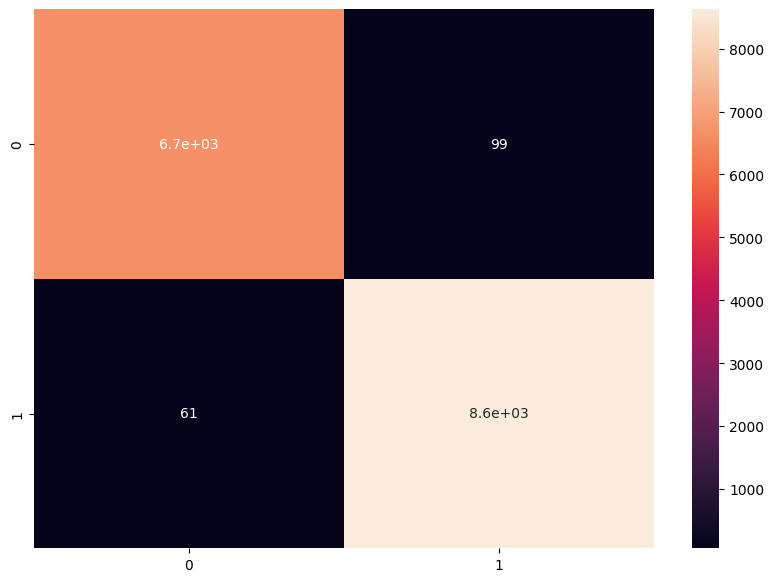

In [30]:
X = df['body']  # Use the 'body' column as features
y = df['label']  # Use the 'label' column as the target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Initialize and train a model (e.g., Logistic Regression)
model = LogisticRegression() # Initialize the model
model.fit(X_train_vec, y_train) # Train the model


y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
# Evaluate the model
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix as a heatmap with seaborn and matplotlib libraries
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True)
plt.show()


# Save Model

In [31]:
# Save the model to disk
model_path = 'model.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(model, file)
# Save the vectorizer to disk
vectorizer_path = 'vectorizer.pkl'
with open(vectorizer_path, 'wb') as file:
    pickle.dump(vectorizer, file)

# Fucntions 

In [32]:
# prompt: create fucntion to fecth the mdel test a body and return true or false
def predict_text(text, model, vectorizer):
    # Transform the input text using the fitted vectorizer
    text_vec = vectorizer.transform([text])
    # Predict the label
    prediction = model.predict(text_vec)
    # Calculate the probability of each class 
    probabilities = model.predict_proba(text_vec)
    # Return True if predicted label is spam (assuming spam is labeled as 1), otherwise False
    is_spam = prediction[0] == 1
    return is_spam, probabilities

def get_suspect_words(text, model, vectorizer, top_n=5):
    # Transform the input text using the fitted vectorizer
    text_vec = vectorizer.transform([text])

    # Get feature names (words) from the vectorizer
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Get model coefficients (importance of each word)
    coef = model.coef_[0]  # Extract coefficients for the positive class

    # Get the nonzero feature indices in the transformed input
    word_indices = text_vec.nonzero()[1]

    # Get word importance scores
    word_importance = coef[word_indices]

    # Pair words with their importance scores and sort them
    word_contributions = sorted(zip(feature_names[word_indices], word_importance), key=lambda x: abs(x[1]), reverse=True)

    # Return the top N suspect words
    return word_contributions[:top_n]
# Example usage
sample_text = "Hay send me your other email so I can forward it to you" 
is_spam, probabilities = predict_text(sample_text, model, vectorizer)
print("Is Spam:", is_spam)
print("Probabilities:", probabilities)
top_words = get_suspect_words(sample_text, model, vectorizer, top_n=5)
print("Top Suspect Words:", top_words)


Is Spam: True
Probabilities: [[0.34407702 0.65592298]]
Top Suspect Words: [('your', np.float64(5.770315312798859)), ('to', np.float64(-3.391357662067492)), ('you', np.float64(3.240028255089539)), ('it', np.float64(-2.8011302459051115)), ('so', np.float64(-2.2925915959283434))]


# Using Fucntion

In [35]:
test_body = "We detected that your password has been exposed in a data breach on another platform while doing a routine check for your security. You should reset your Duolingo password immediately, using a unique password not used elsewhere."
is_spam,percentages = predict_text(test_body, model, vectorizer)
suspect_words = get_suspect_words(test_body, model, vectorizer)

if is_spam:
    print("The body is a phishing email.With a probability of ",percentage[0][1].round(2)*100,"%")
else:
    print("The body is not a phishing email.With a probability of ",percentage[0][0].round(2)*100,"%")

print("Top 5 suspect words:", suspect_words)    

The body is a phishing email.With a probability of  53.0 %
Top 5 suspect words: [('your', np.float64(5.770315312798859)), ('on', np.float64(-4.054767663516126)), ('you', np.float64(3.240028255089539)), ('that', np.float64(-2.6273632467495878)), ('data', np.float64(-2.2529935987741037))]
